# Analysis of multisample with AnnCollection

This notebook performs multisample analysis on data that is created with the sparrow multisample runs.
Warning: The notebook makes use of the experimental AnnData AnnCollection.

***Please adjust the path of the folder below to the path of the multirun you want to analyze***

In [1]:
path_folder = (
    "/srv/scratch/benjaminr/napari-sparrow/logs/segment/multiruns/2022-09-02_00-24-02"
)

In [8]:
%load_ext autoreload
%autoreload 2

import scanpy as sc
import matplotlib.pyplot as plt
from anndata import AnnData
from anndata.experimental import AnnCollection
import yaml
from yaml.loader import SafeLoader
from typing import List
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from napari_sparrow import functions as fc

## Read in the data

In [21]:
def read_in(path_folder: str) -> AnnData:
    # Find all sample folders
    folders = [
        name
        for name in os.listdir(path_folder)
        if os.path.isdir(os.path.join(path_folder, name))
    ]
    print(folders)

    adata_collection = []

    for folder in folders:
        run_folder = path_folder + "/" + folder + "/"

        # If adata file exists, concat to adata folder
        if os.path.exists(run_folder + "adata.h5ad"):
            adata = sc.read(run_folder + "adata.h5ad")

            # Fetch tissue from config if exists
            if os.path.exists(run_folder + ".hydra/config.yaml"):
                with open(run_folder + ".hydra/config.yaml") as infile:
                    data = yaml.load(infile, Loader=SafeLoader)
                    sample = data["dataset"]["image"].split("_")[2]
                    adata.obs["tissue"] = sample
                    adata.obs["group"] = sample.split("-")[0]
            else:
                adata.obs["tissue"] = folder
                print("config file does not exist: \n" + run_folder)

            # Add adata to collection
            adata_collection.append(adata)

        else:
            print("Adata file does not exist:\n" + run_folder + "adata.h5ad")

    # Use join_vars=inner like anndata.concatenate default inner
    adata = AnnCollection(adata_collection, join_vars="inner")
    return adata, folders

In [22]:
import warnings

# Supress anndata dtype warnings
warnings.filterwarnings("ignore", ".*anndata.*")

adata, folders = read_in(path_folder)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32']
Adata file does not exist:
/srv/scratch/benjaminr/napari-sparrow/logs/segment/multiruns/2022-09-02_00-24-02/2/adata.h5ad


/srv/scratch/koends/anaconda3/envs/napari-sparrow/lib/python3.10/site-packages/anndata/experimental/multi_files/_anncollection.py:728: UserWarning: Observation names are not unique.
  warnings.warn("Observation names are not unique.", UserWarning)


TypeError: _merge.<locals>.<lambda>() missing 2 required positional arguments: 'fill_value' and 'axis'

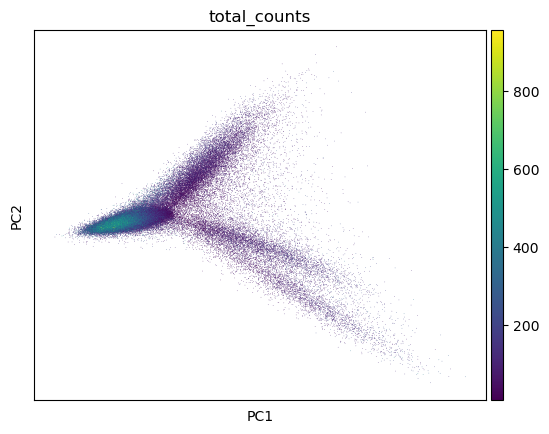

In [ ]:
sc.tl.pca(adata, svd_solver="arpack", n_comps=50)
sc.pl.pca(adata, color="total_counts")

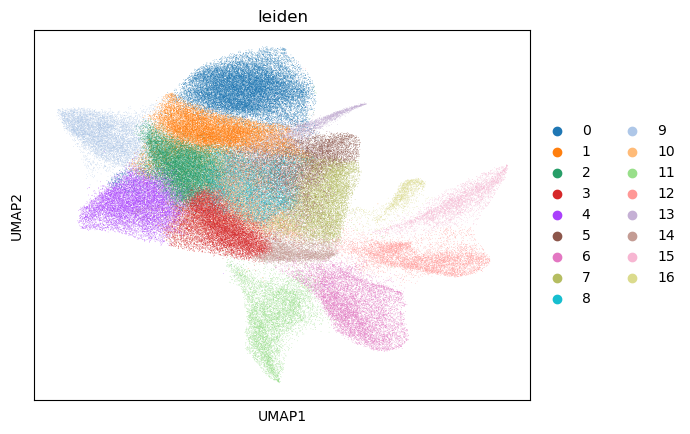

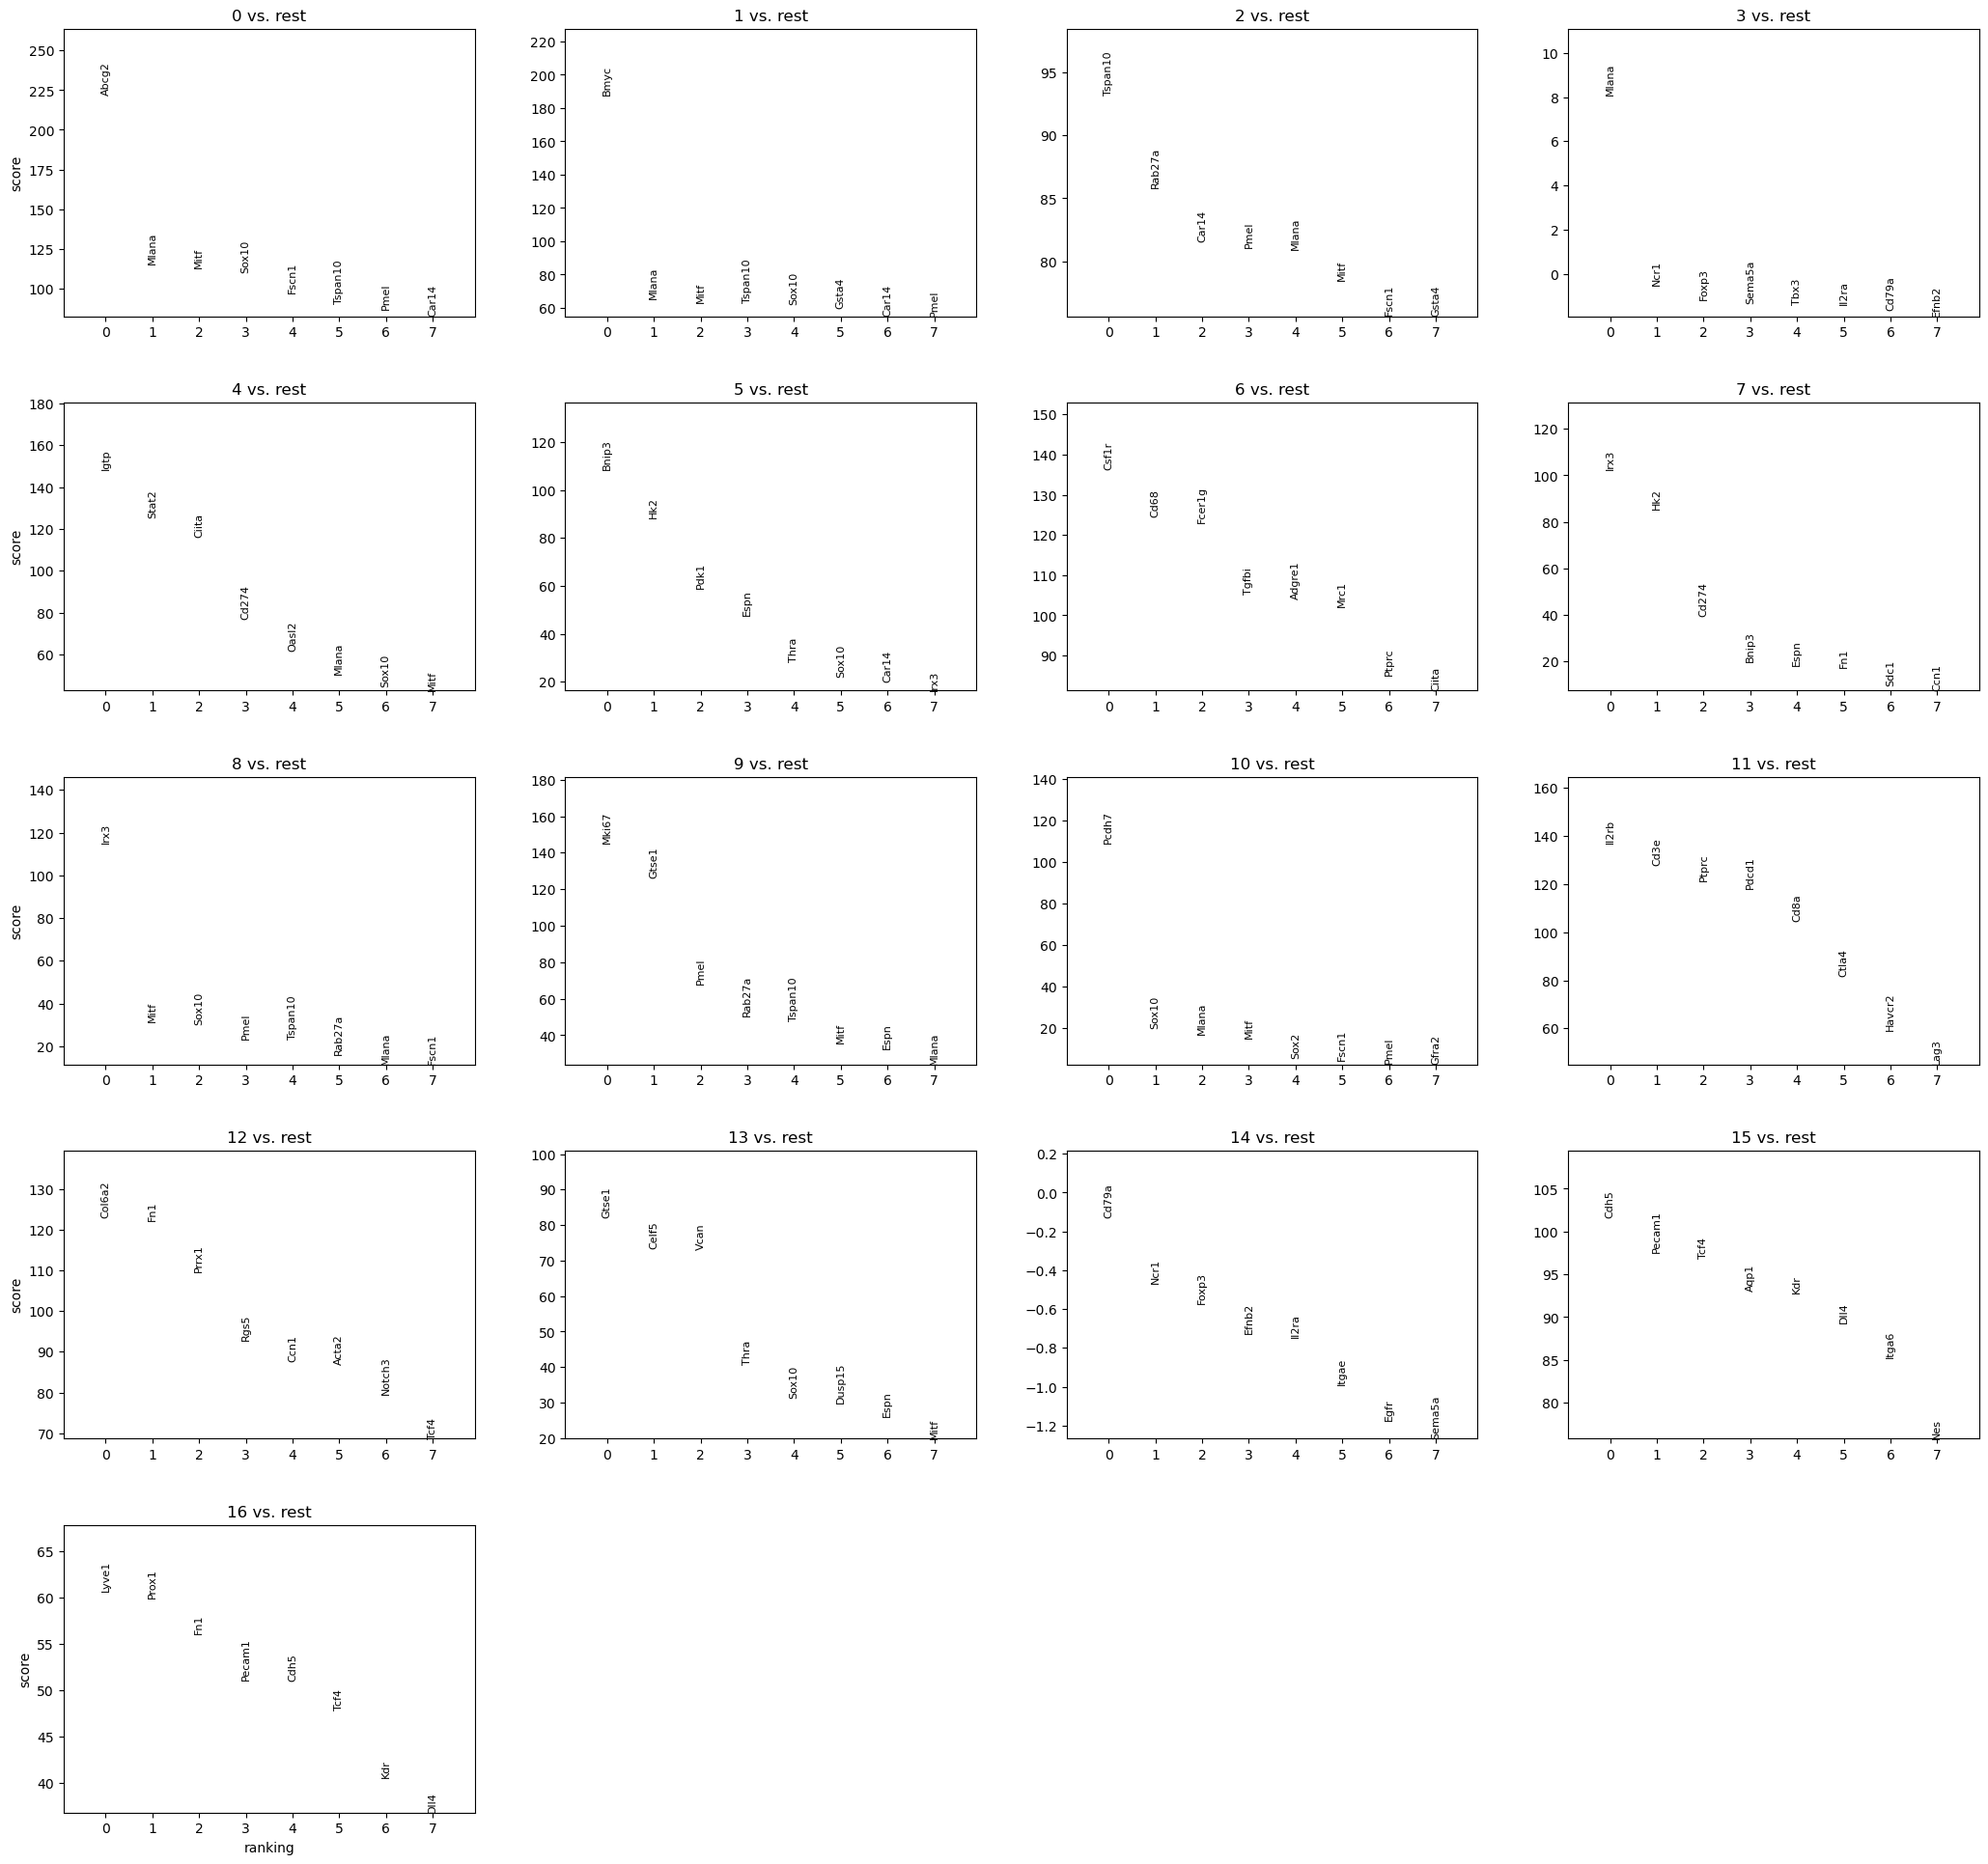

In [ ]:
adata = fc.clustering(adata, 16, 30)
fc.clustering_plot(adata)

(-10.959674739837647, 13.873554134368897, -8.78385603427887, 16.66239559650421)

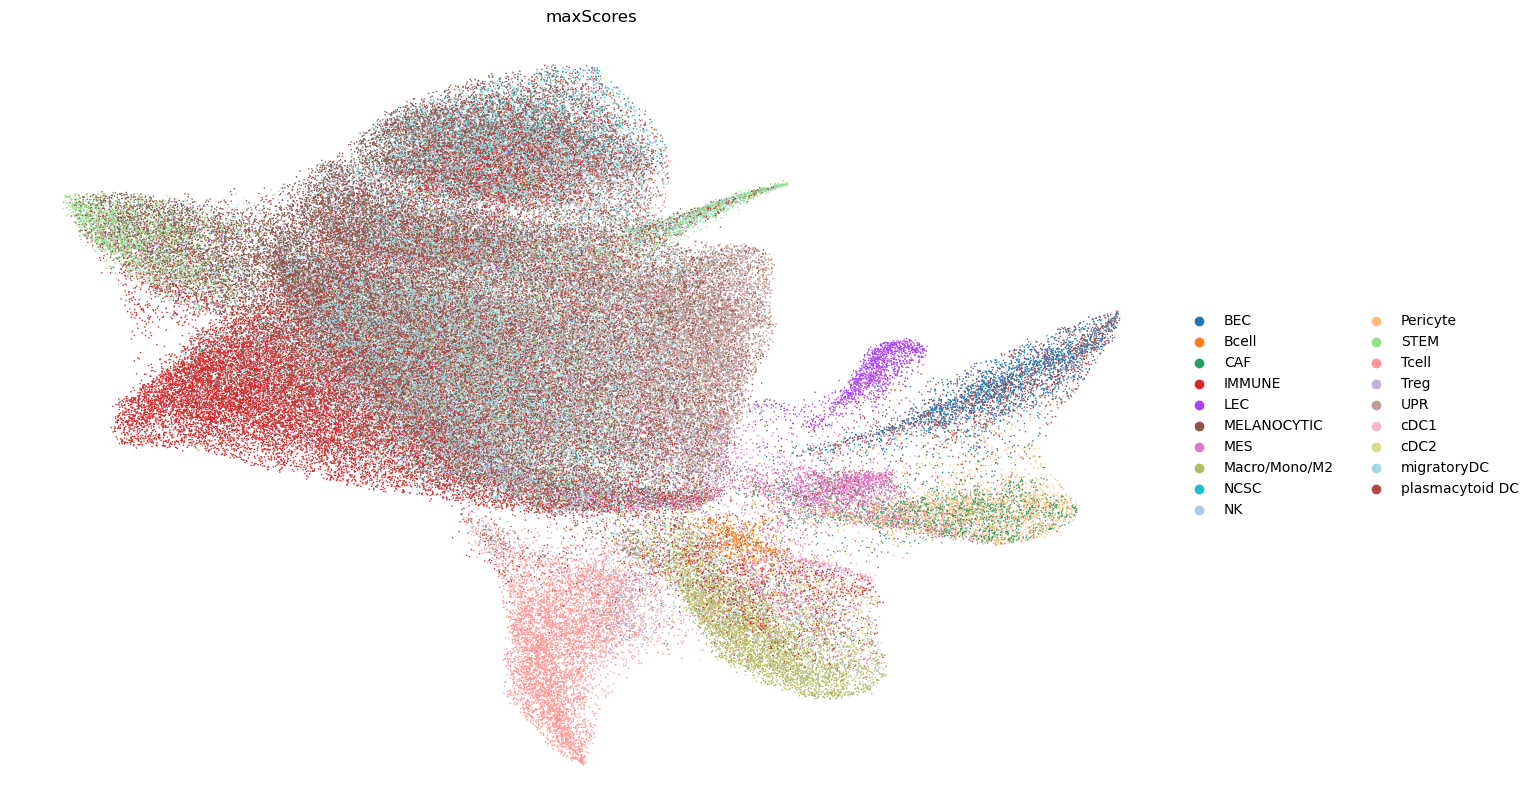

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sc.pl.umap(adata, color=["maxScores"], ax=ax, size=5, show=False)
ax.axis("off")

(-10.959674739837647, 13.873554134368897, -8.78385603427887, 16.66239559650421)

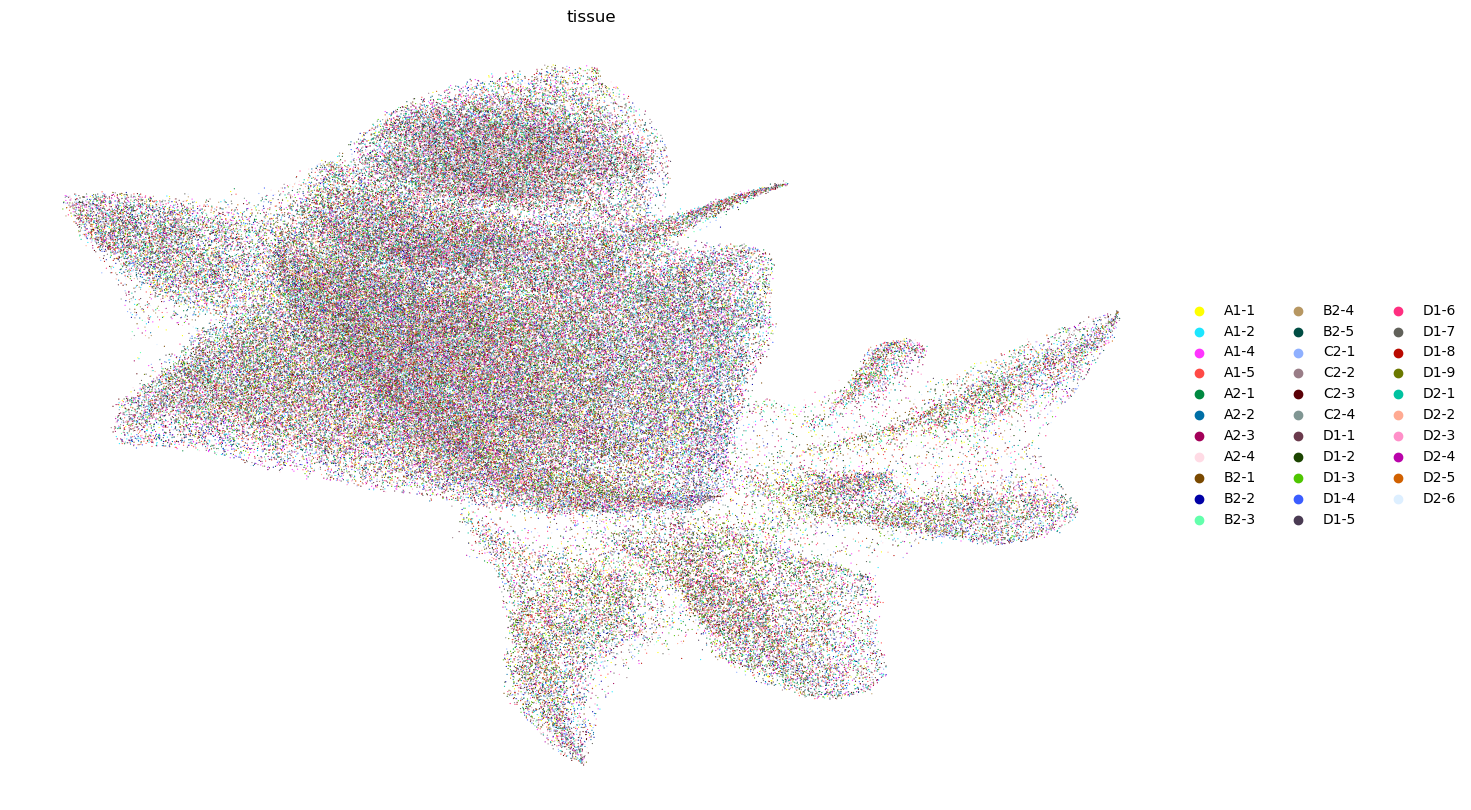

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sc.pl.umap(adata, color=["tissue"], ax=ax, size=3, show=False)
ax.axis("off")

(-10.959674739837647, 13.873554134368897, -8.78385603427887, 16.66239559650421)

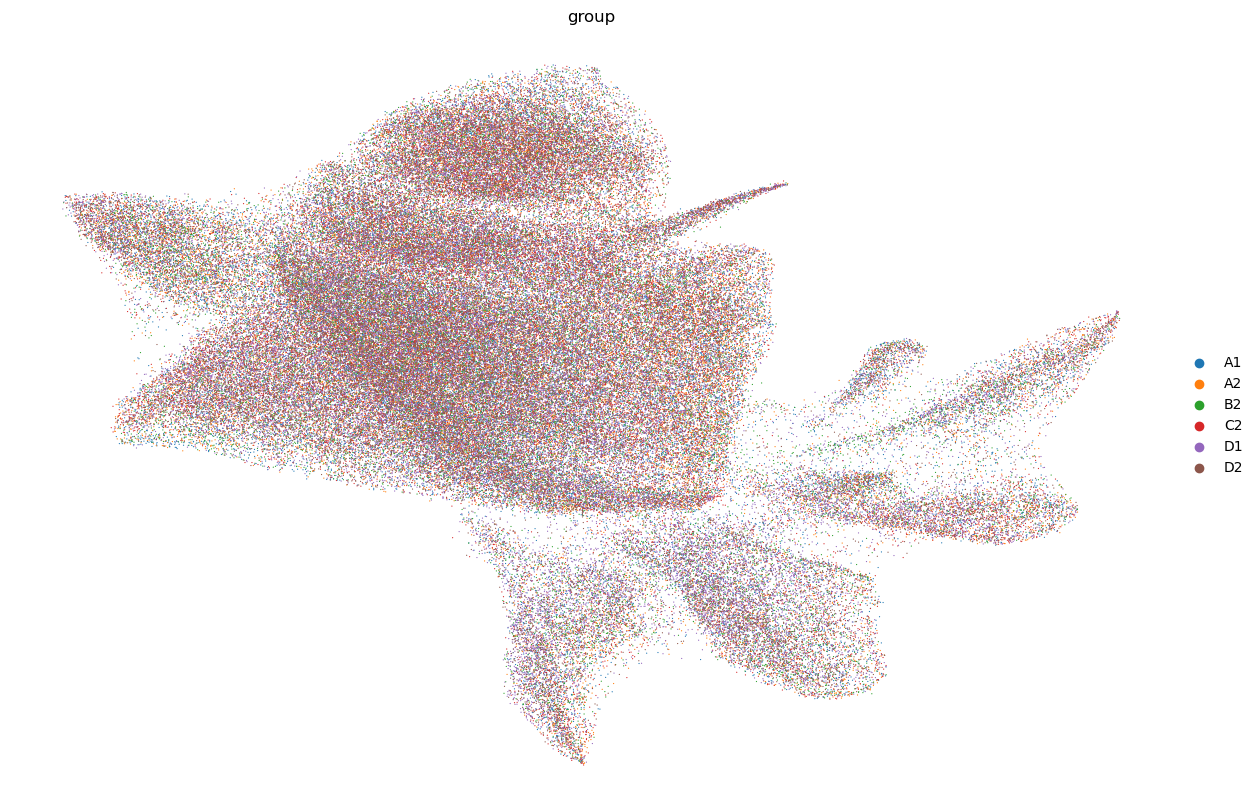

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sc.pl.umap(adata, color=["group"], ax=ax, size=3, show=False)
ax.axis("off")

In [ ]:
def get_markers(path_folder: str, folders: List[str]) -> str:
    run_folder = path_folder + "/" + folders[0] + "/"

    # Fetch markers file from config if exists
    if os.path.exists(run_folder + ".hydra/config.yaml"):
        with open(run_folder + ".hydra/config.yaml") as infile:
            data = yaml.load(infile, Loader=SafeLoader)
            return (
                data["paths"]["data_dir"]
                + data["dataset"]["data_dir"].split("/")[1]
                + "/"
                + data["dataset"]["markers"].split("/")[1]
            )
    else:
        print("Config file does not exist")

Marker file found /srv/scratch/data/spatial/resolve_melanoma/for_Ranks_matrix.csv


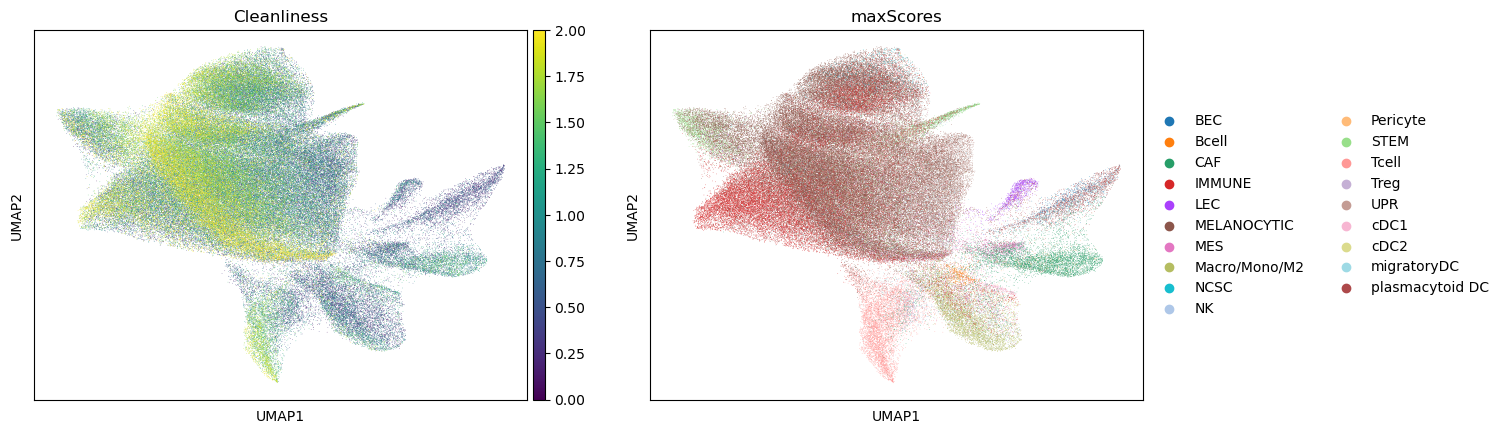

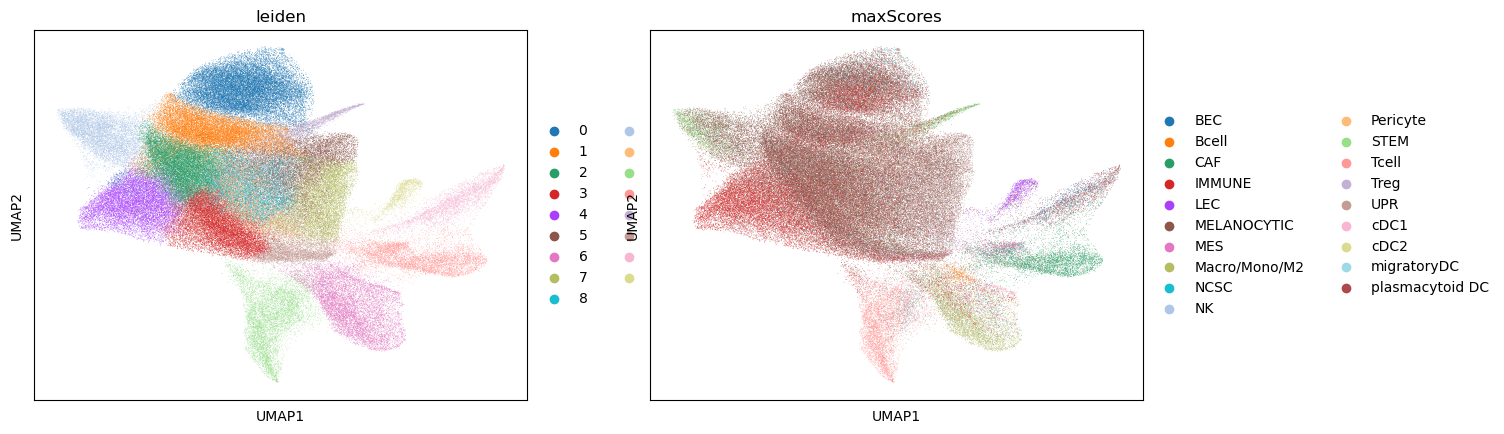

In [ ]:
marker_file = get_markers(path_folder, folders)
print("Marker file found " + marker_file)

# Supress _core_genes futerewarnings
warnings.simplefilter(action="ignore", category=FutureWarning)


mg_dict, scoresper_cluster = fc.scoreGenes(adata, marker_file)
sc.pl.umap(adata, color=["Cleanliness", "maxScores"])
sc.pl.umap(adata, color=["leiden", "maxScores"])

In [ ]:
color_dict = fc.clustercleanliness(adata, list(mg_dict.keys()))

(-10.959674739837647, 13.873554134368897, -8.78385603427887, 16.66239559650421)

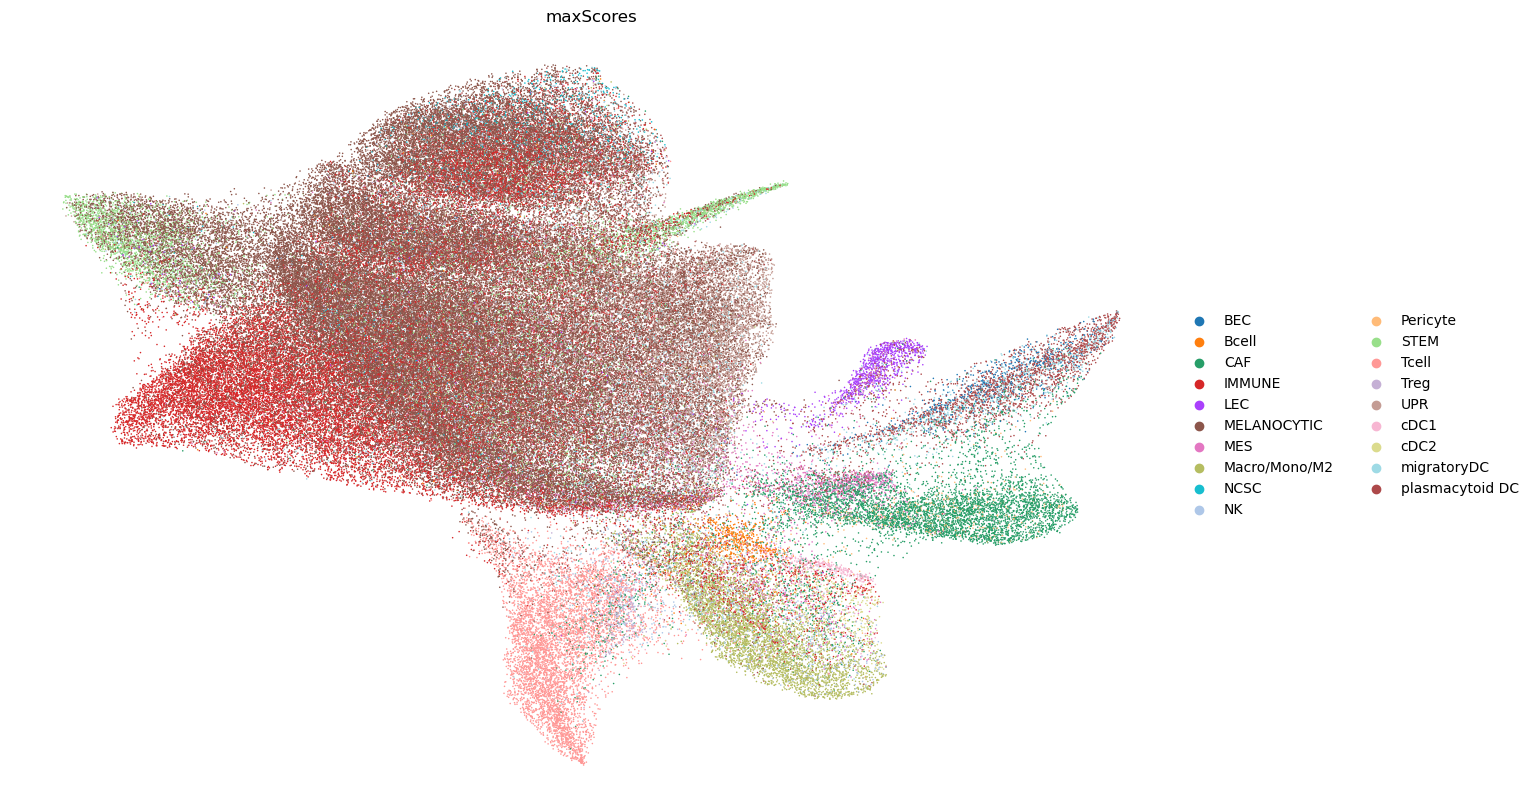

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sc.pl.umap(adata, color=["maxScores"], ax=ax, size=5, show=False)
ax.axis("off")

In [ ]:
adata.obs.tissue = adata.obs.tissue.astype("str").astype("category")
adata.write(path_folder + "/adata.h5ad")